# Viability tube for quadrotor

**Adapted from**: [YAP21, Section V.D] for the model defined in [B12], [M16, Section IV] and [M19, Section 6.1]

[B12] Bouffard, Patrick.
*On-board model predictive control of a quadrotor helicopter: Design, implementation, and experiments.*
CALIFORNIA UNIV BERKELEY DEPT OF COMPUTER SCIENCES, 2012.

[M16] Mitchell, Ian M., et al.
*Ensuring safety for sampled data systems: An efficient algorithm for filtering potentially unsafe input signals.*
2016 IEEE 55th Conference on Decision and Control (CDC). IEEE, 2016.

[M19] Mitchell, Ian M., Jacob Budzis, and Andriy Bolyachevets.
*Invariant, viability and discriminating kernel under-approximation via zonotope scaling.*
Proceedings of the 22nd ACM International Conference on Hybrid Systems: Computation and Control. 2019.

[YAP21] Yin, H., Arcak, M., Packard, A., & Seiler, P. (2021).
*Backward reachability for polynomial systems on a finite horizon.*
IEEE Transactions on Automatic Control, 66(12), 6025-6032.

In [1]:
using DynamicPolynomials
@polyvar x[1:6]
@polyvar u[1:2]
sinx5 = -0.166 * x[5]^3 + x[5]
cosx5 = -0.498 * x[5]^2 + 1
gravity = 9.81
gain_u1 = 0.89 / 1.4
d0 = 70
d1 = 17
n0 = 55
f = [
    x[3],
    x[4],
    0,
    -gravity,
    x[6],
    -d0 * x[5] - d1 * x[6],
]
n_x = length(f)
g = [
    0               0
    0               0
    gain_u1 * sinx5 0
    gain_u1 * cosx5 0
    0               0
    0               n0
]
n_u = size(g, 2)

2

The constraints below are the same as [YAP21, M16, M19] except
[M16, M19] uses different bounds for `x[2]` and
[M16] uses different bounds for `x[5]`

In [2]:
using SumOfSquares
rectangle = [1.7, 0.85, 0.8, 1, π/12, π/2, 1.5, π/12]
X = BasicSemialgebraicSet(FullSpace(), typeof(x[1] + 1.0)[])
function rect(vars, bounds)
    R = BasicSemialgebraicSet(FullSpace(), typeof(vars[1] + 1.0)[])
    for (var, bound) in zip(vars, bounds)
        lower = var + bound # var >= -bound
        upper = bound - var # var <=  bound
        addinequality!(R, lower * upper) # -bound <= var <= bound
    end
    return R
end
X = rect(x, rectangle[1:n_x])
U = rect(u, rectangle[n_x .+ (1:n_u)])

# Controller for the linearized system

Basic semialgebraic Set defined by no equality
2 inequalities
 -u[1]^2 + 2.25 ≥ 0
 -u[2]^2 + 0.06853891945200942 ≥ 0


The starting value for the Lyapunov function is the linear state-feedback
that maintains the quadrotor at the origin [YAP21, Remark 3].

In [3]:
using SparseArrays
x0 = zeros(n_x)
u0 = [gravity/gain_u1, 0.0]

2-element Vector{Float64}:
 15.431460674157302
  0.0

The linearization of `f` is given by

In [4]:
x_dot = f + g * u
A = map(differentiate(x_dot, x)) do a
    a(x => x0, u => u0)
end

6×6 Matrix{Float64}:
 0.0  0.0  1.0  0.0    0.0     0.0
 0.0  0.0  0.0  1.0    0.0     0.0
 0.0  0.0  0.0  0.0    9.81    0.0
 0.0  0.0  0.0  0.0   -0.0     0.0
 0.0  0.0  0.0  0.0    0.0     1.0
 0.0  0.0  0.0  0.0  -70.0   -17.0

The linearization of `g` is given by:

In [5]:
B = map(differentiate(x_dot, u)) do b
    b(x => x0, u => u0)
end

6×2 Matrix{Float64}:
 0.0        0.0
 0.0        0.0
 0.0        0.0
 0.635714   0.0
 0.0        0.0
 0.0       55.0

We can compute the Linear-Quadratic Regulator using the same weight matrices
as [YAP21](https://github.com/heyinUCB/Backward-Reachability-Analysis-and-Control-Synthesis)

In [6]:
import MatrixEquations
S, v, K = MatrixEquations.arec(A, B, 100, 10)

([16.292570148878525 0.0 … 15.57480749908159 0.574959574576061; 0.0 33.088878352322595 … 0.0 0.0; … ; 15.57480749908159 0.0 … 77.86450881960069 2.351871927540147; 0.574959574576061 0.0 … 2.351871927540147 0.33350499830322966], ComplexF64[-20.971921374731764 + 0.0im, -2.4996333869823575 + 1.0164311596191538im, -2.4996333869823575 - 1.0164311596191538im, -1.1173380499762577 + 0.0im, -0.33259370187172294 + 0.3006857792973822im, -0.33259370187172294 - 0.3006857792973822im], [0.0 0.31622776601684865 … 0.0 0.0; 0.31622776601683356 0.0 … 1.2935295601470809 0.18342774906677634], [0.0008060840908009163 -0.05613784763082957 … 0.0 0.0; -0.0 0.0 … -0.05775148048980027 8.149556229787109e-7; … ; 0.0 0.0 … 0.0018349064418763817 -0.006085236874990803; -0.10073117837318402 -0.04838241677276748 … 0.0 0.0])

The corresponding quadratic regulator is:

In [7]:
P, _, _ = MatrixEquations.arec(A - B * K, 0.0, 10.0)

([15.079325210368138 -6.857708609448471e-13 … 11.779773454129337 0.28747978728801243; -6.857708609448471e-13 25.5721996361255 … -9.745025598003555e-13 -3.256874147853097e-14; … ; 11.779773454129337 -9.745025598003555e-13 … 61.48334575956294 1.2180389614142224; 0.28747978728801243 -3.256874147853097e-14 … 1.2180389614142224 0.22954511869010072], ComplexF64[-20.971921374731608 + 0.0im, -2.499633386982368 + 1.016431159619156im, -2.499633386982368 - 1.016431159619156im, -1.1173380499763044 + 0.0im, -0.33259370187175674 + 0.3006857792974213im, -0.33259370187175674 - 0.3006857792974213im], [0.0006214691095206836 0.007946975034554656 … 1.6714060691034878e-15 8.954635892463707e-16; -9.316938956384757e-17 -7.25934027872733e-16 … 0.03297116155195674 0.09042716026990513; … ; 0.7869136542429942 -0.596551483703003 … 1.1065475792602884e-14 7.678763825419691e-15; -0.10521085477131374 -0.1447426448698003 … 8.215650382224898e-15 6.800447137902293e-15])

It corresponds to the following quadratic Lyapunov function:

In [8]:
V0 = x' * P * x

15.079325210368138x₁² - 1.3715417218896943e-12x₁x₂ + 12.591408551923372x₁x₃ - 3.3414032580348453e-12x₁x₄ + 23.559546908258675x₁x₅ + 0.5749595745760249x₁x₆ + 25.5721996361255x₂² - 1.0097607201406337e-12x₂x₃ + 49.743693530734134x₂x₄ - 1.949005119600711e-12x₂x₅ - 6.513748295706194e-14x₂x₆ + 8.052884169427871x₃² - 2.3736542260519836e-12x₃x₄ + 34.030386219979974x₃x₅ + 0.7972435614145383x₃x₆ + 44.90741495893652x₄² - 4.660412900101268e-12x₄x₅ - 1.610574609794836e-13x₄x₆ + 61.48334575956294x₅² + 2.436077922828445x₅x₆ + 0.22954511869010072x₆²

We can see that many terms have a coefficient that is almost zero:

In [9]:
[monomial(t) for t in terms(V0) if abs(DynamicPolynomials.coefficient(t)) < 1e-8]

8-element Vector{DynamicPolynomials.Monomial{true}}:
 x₁x₂
 x₁x₄
 x₂x₃
 x₂x₅
 x₂x₆
 x₃x₄
 x₄x₅
 x₄x₆

This might cause troubles in the optimization so let's drop them:

In [10]:
V0 = mapcoefficients(c -> (abs(c) < 1e-8 ? 0.0 : c), V0)

15.079325210368138x₁² + 12.591408551923372x₁x₃ + 23.559546908258675x₁x₅ + 0.5749595745760249x₁x₆ + 25.5721996361255x₂² + 49.743693530734134x₂x₄ + 8.052884169427871x₃² + 34.030386219979974x₃x₅ + 0.7972435614145383x₃x₆ + 44.90741495893652x₄² + 61.48334575956294x₅² + 2.436077922828445x₅x₆ + 0.22954511869010072x₆²

## γ-step

It is a Lyapunov function for the linear system but not necessarily for the nonlinear system as well.
We can however say that the γ-sublevel set `{x | x' P x ≤ γ}` is a (trivial) controlled invariant set for `γ = 0` (since it is empty).
We can try to see if there a larger `γ` such that the γ-sublevel set is also controlled invariant using
the γ step of [YAP21, Algorithm 1]

In [11]:
function _create(model, d)
    if d isa Int
        return @variable(model, variable_type = Poly(monomials(x, 0:d)))
    else
        return d
    end
end

using LinearAlgebra
function base_model(solver, V, k, s3, γ)
    model = SOSModel(solver)
    V = _create(model, V)
    k = _create.(model, k)
    ∂ = differentiate # Let's use a fancy shortcut
    dV = ∂(V, x) ⋅ (f + g * k)
    if s3 isa Int # [YAP21, (E.2)]
        @constraint(model, con, dV <= 0, domain = @set(V <= γ))
    else
        @constraint(model, dV <= s3 * (V - γ))
    end
    for r in inequalities(X) # `{V ≤ γ} ⊆ {r ≥ 0}` iff `r ≤ 0 => V ≥ γ`
        @constraint(model, V >= γ, domain = @set(r <= 0)) # [YAP21, (E.3)]
    end
    return model, V, k, s3
end

function γ_step(solver, V, γ_min, degree_k, degree_s3; γ_tol = 1e-1, max_iters = 10, γ_step = 0.5)
    γ0_min = γ_min
    γ_max = Inf
    num_iters = 0
    k_best = s3_best = nothing
    while true
        if γ_max - γ_min > γ_tol && num_iters < max_iters
            if isfinite(γ_max)
                γ = (γ_min + γ_max) / 2
            else
                γ = γ0_min + (γ_min - γ0_min + γ_step) * 2
            end
        elseif isnothing(k_best)
            @assert γ_min == γ0_min
            @info("Bisection finished without a feasible controller, let's find one")
            γ = γ0_min # Last run to compute a controller for the value of `γ` we know is feasible
        else
            break
        end
        model, V, k = base_model(solver, V, degree_k, degree_s3, γ)
        num_iters += 1
        @info("Iteration $num_iters/$max_iters : Solving with $(solver_name(model)) for `γ = $γ`")
        optimize!(model)
        @info("After $(solve_time(model)) seconds, terminated with $(termination_status(model)) ($(raw_status(model)))")
        if primal_status(model) == MOI.FEASIBLE_POINT || primal_status(model) == MOI.NEARLY_FEASIBLE_POINT
            @info("Feasible solution found : primal is $(primal_status(model))")
            γ_min = γ
            k_best = value.(k)
            s3_best = lagrangian_multipliers(model[:con])[1]
        elseif dual_status(model) == MOI.INFEASIBILITY_CERTIFICATE
            @info("Infeasibility certificate found : dual is $(dual_status(model))")
            if γ == γ0_min # This corresponds to the case above where we reached the tol or max iteration and we just did a last run at the value of `γ_min` provided by the user
                error("The value `$γ0_min` of `γ_min` provided is not feasible")
            end
            γ_max = γ
        else
            @warn("Giving up $(raw_status(model)), $(termination_status(model)), $(primal_status(model)), $(dual_status(model))")
            break
        end
        if γ != γ0_min
            @info("Refined interval : `γ ∈ [$γ_min, $γ_max[`")
        end
    end
    if !isfinite(γ_max) && max_iters > 0
        @warn("Cannot find any infeasible `γ` after $num_iters iterations")
    end
    return γ_min, k_best, s3_best
end

import CSDP
solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
γ1, κ1, s3_1 = γ_step(solver, V0, 0.0, [2, 2], 2)
nothing

[ Info: Iteration 1/10 : Solving with CSDP for `γ = 1.0`
[ Info: After 3.1061060428619385 seconds, terminated with INFEASIBLE (Problem is primal infeasible.)
[ Info: Infeasibility certificate found : dual is INFEASIBILITY_CERTIFICATE
[ Info: Refined interval : `γ ∈ [0.0, 1.0[`
[ Info: Iteration 2/10 : Solving with CSDP for `γ = 0.5`
[ Info: After 2.4588589668273926 seconds, terminated with OPTIMAL (Problem solved to optimality.)
[ Info: Feasible solution found : primal is FEASIBLE_POINT
[ Info: Refined interval : `γ ∈ [0.5, 1.0[`
[ Info: Iteration 3/10 : Solving with CSDP for `γ = 0.75`
[ Info: After 3.899221181869507 seconds, terminated with INFEASIBLE (Problem is primal infeasible.)
[ Info: Infeasibility certificate found : dual is INFEASIBILITY_CERTIFICATE
[ Info: Refined interval : `γ ∈ [0.5, 0.75[`
[ Info: Iteration 4/10 : Solving with CSDP for `γ = 0.625`
[ Info: After 4.1833789348602295 seconds, terminated with INFEASIBLE (Problem is primal infeasible.)
[ Info: Infeasibility cer

The best `γ` found is

In [12]:
γ1

0.5

with state feedback:

In [13]:
κ1

2-element Vector{DynamicPolynomials.Polynomial{true, Float64}}:
 12.60083258925772x₁² - 3.979039320256561e-13x₁x₂ + 35.15479195476178x₁x₃ + 3.410605131648481e-13x₁x₄ + 48.47102849256112x₁x₅ + 17.103130345797865x₁x₆ + 5.502954191406559x₂² - 1.2505552149377763e-12x₂x₃ + 17.23804610032056x₂x₄ - 1.1937117960769683e-12x₂x₅ - 5.115907697472721e-13x₂x₆ + 23.57567901522691x₃² - 7.389644451905042e-13x₃x₄ + 65.17572911533688x₃x₅ + 22.523046653403583x₃x₆ + 13.503184271171392x₄² + 2.0463630789890885e-12x₄x₅ - 5.684341886080802e-14x₄x₆ + 19.140157098593022x₅² + 42.15689538008155x₅x₆ + 5.016097148259348x₆² - 1.1368683772161603e-13x₁ - 111.52528047646081x₂ - 1.7053025658242404e-13x₃ - 202.21460128017125x₄ - 4.547473508864641e-13x₅ - 1.1368683772161603e-13x₆ + 15.431460674312177
 -8.310736080754907x₁x₂ - 5.684341886080802e-14x₁x₃ - 14.95165548306818x₁x₄ - 5.684341886080802e-14x₁x₅ - 1.1368683772161603e-13x₁x₆ + 5.115907697472721e-13x₂² - 11.446188522147622x₂x₃ + 3.979039320256561e-13x₂x₄ + 13.54358128

Let's visualize now the controlled invariant set we have found:

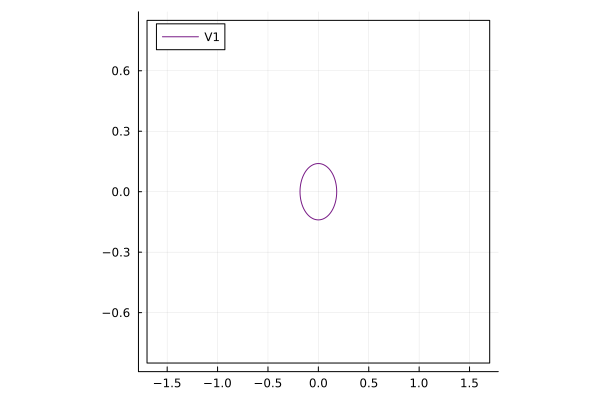

In [14]:
using ImplicitPlots
using Plots
import ColorSchemes
function plot_lyapunovs(Vs, J; resolution = 1000, scheme = ColorSchemes.rainbow)
    xmax = rectangle[J[1]]
    ymax = rectangle[J[2]]
    rect_xs = [xmax, -xmax, -xmax, xmax, xmax]
    rect_ys = [ymax, ymax, -ymax, -ymax, ymax]
    p = plot(rect_xs, rect_ys, label="", color=:black)
    eliminated = x[setdiff(1:n_x, J)]
    for i in eachindex(Vs)
        V = subs(Vs[i], eliminated => zeros(length(eliminated)))
        linecolor = get(scheme, (i - 1) / max(length(Vs) - 1, 1))
        implicit_plot!(p, V; resolution, label="V$i", linecolor)
    end
    xlim = 1.05 * xmax
    ylim = 1.05 * ymax
    plot!(p, xlims=(-xlim, xlim), ylims=(-ylim, ylim), aspect_ratio = xmax / ymax)
    return p
end
Vs = [V0 - γ1]
plot_lyapunovs(Vs, [1, 2])

## V-step

Let's now fix the control law that we have found and try to find a superset
of the current controlled invariant set
That corresponds to the V-step of [YAP21, Algorithm 1]:

In [15]:
_degree(d::Int) = d
_degree(V) = maxdegree(V)

function V_step(solver, V0, γ, k, s3)
    model, V, k, s3 = base_model(solver, _degree(V0), k, s3, γ)
    if !(V0 isa Int) # {V0 ≤ γ} ⊆ {V ≤ γ} iff V0 ≤ γ => V ≤ γ
        @constraint(model, V <= γ, domain = @set(V0 <= γ)) # [YAP21, (E.6)]
    end
    optimize!(model)
    return model, value(V)
end

model, V1 = V_step(solver, V0, γ1, κ1, s3_1)
nothing # hide

We can see that the solver found a feasible solution.

In [16]:
solution_summary(model)

* Solver : CSDP

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Problem solved to optimality."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 0.00000e+00
  Dual objective value : 0.00000e+00

* Work counters
  Solve time (sec)   : 4.88492e+00


Let's compare it:

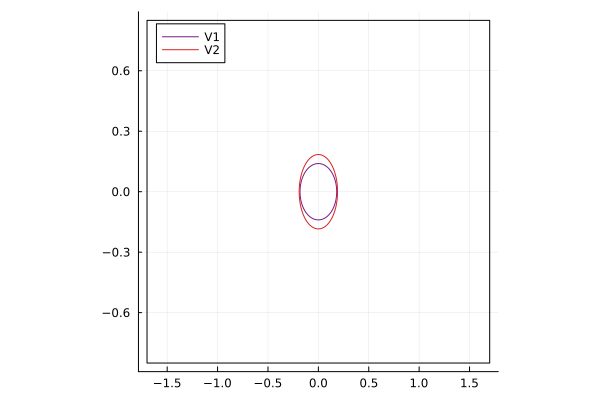

In [17]:
push!(Vs, V1 - γ1)
plot_lyapunovs(Vs, [1, 2])

## Continue iterating

We could now find a better state feedback controller with this new Lyapunov.
Given the plot, we see that `γ` cannot be much improved, we mostly
want to find a better `κ` so let's set `max_iters` to zero

In [18]:
γ2, κ2, s3_2 = γ_step(solver, V0, γ1, [2, 2], 2, max_iters = 0)
nothing # hide

[ Info: Bisection finished without a feasible controller, let's find one
[ Info: Iteration 1/0 : Solving with CSDP for `γ = 0.5`
[ Info: After 2.615131139755249 seconds, terminated with OPTIMAL (Problem solved to optimality.)
[ Info: Feasible solution found : primal is FEASIBLE_POINT


Let's see if this new controller allows to find a better Lyapunov.

In [19]:
model, V2 = V_step(solver, V0, γ2, κ2, s3_2)
solution_summary(model)

* Solver : CSDP

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Problem solved to optimality."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 0.00000e+00
  Dual objective value : 0.00000e+00

* Work counters
  Solve time (sec)   : 4.38686e+00


It does not seem that we gained any improvement so let's stop:

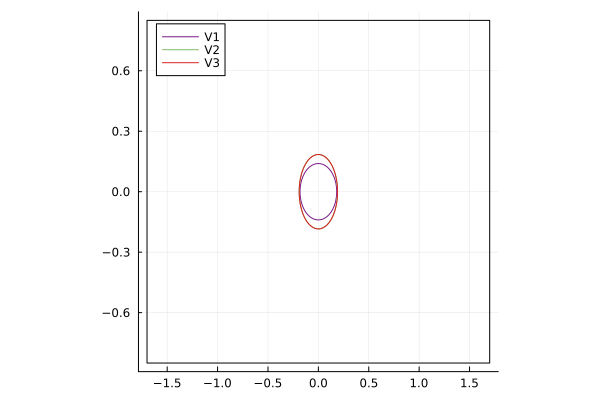

In [20]:
push!(Vs, V2 - γ2)
plot_lyapunovs(Vs, [1, 2])

## Different starting point

The LQR regulator we computed as starting point does not take the
the constraints `X` into account.
To take the constraint into account,
we compute an ellipsoidal control invariant set using [LJ21, Corollary 9]
For this, we first compute the descriptor system described in [LJ21, Proposition 5].

[LJ21] Legat, Benoît, and Jungers, Raphaël M.
*Geometric control of algebraic systems.*
IFAC-PapersOnLine 54.5 (2021): 79-84.

In [21]:
nD = n_x + n_u
E = sparse(1:n_x, 1:n_x, ones(n_x), n_x, nD)
C = [A B]

6×8 Matrix{Float64}:
 0.0  0.0  1.0  0.0    0.0     0.0  0.0        0.0
 0.0  0.0  0.0  1.0    0.0     0.0  0.0        0.0
 0.0  0.0  0.0  0.0    9.81    0.0  0.0        0.0
 0.0  0.0  0.0  0.0   -0.0     0.0  0.635714   0.0
 0.0  0.0  0.0  0.0    0.0     1.0  0.0        0.0
 0.0  0.0  0.0  0.0  -70.0   -17.0  0.0       55.0

We know solve [LJ21, (13)]

In [22]:
using LinearAlgebra
model = Model(solver)
@variable(model, Q[1:nD, 1:nD] in PSDCone())
cref = @constraint(model, Symmetric(-C * Q * E' - E * Q * C') in PSDCone())
@constraint(model, rect_ref[i in 1:nD], Q[i, i] <= rectangle[i]^2)
@variable(model, volume)
q = [Q[i, j] for j in 1:nD for i in 1:j]
@constraint(model, [volume; q] in MOI.RootDetConeTriangle(nD))
@objective(model, Max, volume)
optimize!(model)
solution_summary(model)

* Solver : CSDP

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Problem solved to optimality."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 5.78738e-01
  Dual objective value : 5.78738e-01

* Work counters
  Solve time (sec)   : 3.41403e-01


We now have the control-Lyapunov function `V(x, u) = [x, u]' inv(Q) [x, u]`.
In other words, The 1-sublevel set of `V(x, u)` is an invariant subset of `rectangle`
with any state-feedback `κ(x)` such that `V(x, κ(x)) ≤ 1` for any `x` such that
`min_u V(x, u) ≤ 1`.
Such candidate `κ(x)` can therefore be chosen as `argmin_u V(x, u)`.
Let `inv(Q) = U' * U` where `U = [Ux Uu]`. We have `V(x, u) = ||Ux * x + Uu * u||_2`.
`κ(x)` is therefore the least-square solution of `Uu * κ(x) = -Ux * x`.
This we find the linear state-feedback `κ(x) = K * x` where `K = -Uu \ Ux`.

In [23]:
P = inv(Symmetric(value.(Q)))
using LinearAlgebra
F = cholesky(P)
K = -F.U[:, (n_x + 1):(nD)] \ F.U[:, 1:n_x] # That gives the following state feedback in polynomial form:

2×6 Matrix{Float64}:
  0.0        -0.882353   0.0        -0.833058   0.0        0.0
 -0.0222194   0.0       -0.0694124   0.0       -0.129141  -0.00421917

The corresponding polynomial form is given by:

In [24]:
κ0 = K * x

2-element Vector{DynamicPolynomials.Polynomial{true, Float64}}:
 -0.882352735630361x₂ - 0.83305782987962x₄
 -0.022219408717766776x₁ - 0.06941238949828189x₃ - 0.12914146540936053x₅ - 0.004219173792328508x₆

We now have two equivalent ways to obtain the Lyapunov function.
Because `{V(x) ≤ 1} = {min_u V(x, u) ≤ 1}`,
see the left-hand side as the projection of the ellipsoid on `x, u`.
As the projection on the polar becomes simply cutting with the hyperplane `u = 0`,
the polar of the projection is simply `Q[1:6, 1:6]` ! So

In [25]:
Px = inv(Symmetric(value.(Q[1:n_x, 1:n_x])))

6×6 LinearAlgebra.Symmetric{Float64, Matrix{Float64}}:
 0.353394   0.0       0.0534157  0.0        0.351086  0.0166669
 0.0        1.55709   0.0        0.490034   0.0       0.0
 0.0534157  0.0       1.87417    0.0        1.84556   0.295246
 0.0        0.490034  0.0        1.38797    0.0       0.0
 0.351086   0.0       1.84556    0.0       17.0444    0.697153
 0.0166669  0.0       0.295246   0.0        0.697153  0.462644

An alternative way is to use our linear state feedback.
We know that `min_u V(x, u) = V(x, Kx)` so

In [26]:
Px = [I; K]' * P * [I; K]

6×6 Matrix{Float64}:
 0.353394   0.0       0.0534157  0.0        0.351086  0.0166669
 0.0        1.55709   0.0        0.490034   0.0       0.0
 0.0534157  0.0       1.87417    0.0        1.84556   0.295246
 0.0        0.490034  0.0        1.38797    0.0       0.0
 0.351086   0.0       1.84556    0.0       17.0444    0.697153
 0.0166669  0.0       0.295246   0.0        0.697153  0.462644

We can double check that this matrix is negative definite:

In [27]:
eigen(Symmetric(Px * (A + B * K) + (A + B * K)' * Px)).values

6-element Vector{Float64}:
 -83.44264967502772
  -4.59071600130032
  -1.0397781704180302
  -6.822088606976983e-9
  -1.3081766843554856e-9
  -1.0129560642136006e-9

Let's use the `support_` prefix to differentiate since we obtained it
with the support function.
The corresponding Lyapunov is:

In [28]:
support_V0 = x' * Px * x

0.35339440227767954x₁² + 0.10683141910803211x₁x₃ + 0.7021723219158447x₁x₅ + 0.033333840285734204x₁x₆ + 1.557093407343589x₂² + 0.980068157454626x₂x₄ + 1.8741658275022288x₃² + 3.6911284527569457x₃x₅ + 0.5904925002177625x₃x₆ + 1.3879711934338639x₄² + 17.044390822542333x₅² + 1.3943053465004982x₅x₆ + 0.4626437564254304x₆²

We can see that `support_V0` shares the same monomial with almost zero coefficient
with `V0`.

In [29]:
[monomial(t) for t in terms(support_V0) if abs(DynamicPolynomials.coefficient(t)) < 1e-8]

DynamicPolynomials.Monomial{true}[]

Let's drop them for `support_V0` as well:

In [30]:
support_V0 = mapcoefficients(c -> (abs(c) < 1e-8 ? 0.0 : c), support_V0)

0.35339440227767954x₁² + 0.10683141910803211x₁x₃ + 0.7021723219158447x₁x₅ + 0.033333840285734204x₁x₆ + 1.557093407343589x₂² + 0.980068157454626x₂x₄ + 1.8741658275022288x₃² + 3.6911284527569457x₃x₅ + 0.5904925002177625x₃x₆ + 1.3879711934338639x₄² + 17.044390822542333x₅² + 1.3943053465004982x₅x₆ + 0.4626437564254304x₆²

`support_V0 - 1` is a controlled invariant set for the linearized system
but not for the nonlinear one. We can plot it to visualize but
it is not comparable to the ones found before which were
controlled invariant to the nonlinear system.

In [31]:
support_Vs = [support_V0 - 1]
plot_lyapunovs(support_Vs, [1, 2])

support_γ1, support_κ1, support_s3_1 = γ_step(solver, support_V0, 0.0, [2, 2], 2)

[ Info: Iteration 1/10 : Solving with CSDP for `γ = 1.0`
[ Info: After 5.179563999176025 seconds, terminated with INFEASIBLE (Problem is primal infeasible.)
[ Info: Infeasibility certificate found : dual is INFEASIBILITY_CERTIFICATE
[ Info: Refined interval : `γ ∈ [0.0, 1.0[`
[ Info: Iteration 2/10 : Solving with CSDP for `γ = 0.5`
[ Info: After 5.768848180770874 seconds, terminated with INFEASIBLE (Problem is primal infeasible.)
[ Info: Infeasibility certificate found : dual is INFEASIBILITY_CERTIFICATE
[ Info: Refined interval : `γ ∈ [0.0, 0.5[`
[ Info: Iteration 3/10 : Solving with CSDP for `γ = 0.25`
[ Info: After 5.565197944641113 seconds, terminated with INFEASIBLE (Problem is primal infeasible.)
[ Info: Infeasibility certificate found : dual is INFEASIBILITY_CERTIFICATE
[ Info: Refined interval : `γ ∈ [0.0, 0.25[`
[ Info: Iteration 4/10 : Solving with CSDP for `γ = 0.125`
[ Info: After 6.688314914703369 seconds, terminated with INFEASIBLE (Problem is primal infeasible.)
[ Info: 

(0.0, DynamicPolynomials.Polynomial{true, Float64}[3.6634328684326576x₁² + 0.03855324936446891x₁x₃ - 0.19264060364434954x₁x₅ - 0.050673807412010774x₁x₆ + 2.137524837484577x₂² - 0.8020104474119663x₂x₄ + 3.0384312576747945x₃² + 0.340111184337367x₃x₅ - 0.4362077845329324x₃x₆ + 2.2344314147914517x₄² + 2.842170943040401e-14x₄x₆ - 1.347423513642994x₅² - 0.4313854734051077x₅x₆ + 2.3561100186279305x₆² - 1.4210854715202004e-14x₁ + 4.967945920073092x₂ - 10.848853207705211x₄ + 15.43146067415745, 0.0005234958340878393x₁x₂ + 0.002894836622147068x₁x₄ + 7.105427357601002e-15x₁x₆ - 0.06743908823044364x₂x₃ - 7.105427357601002e-15x₂x₄ - 0.03719459828977989x₂x₅ - 0.0038765491433494503x₂x₆ + 0.07969308901426331x₃x₄ + 1.4210854715202004e-14x₃x₅ + 7.105427357601002e-15x₄² + 0.5054118521266631x₄x₅ - 0.15241134533741985x₄x₆ + 7.105427357601002e-15x₅² + 1.4210854715202004e-14x₅x₆ + 1.1080799655456772x₁ - 0.41111946560260293x₃ + 56.37065204403887x₅ - 20.98632711878451x₆], GramMatrix{Float64, MonomialBasis{Dynam

We do not find it for any positive `γ` so the controlled invariant set is an empty set.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*